In [1]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import torch
import scipy.sparse as sp

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "/Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation"



/Users/jessica/mambaforge/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [167]:
adata_cd4= sc.read_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_preprocessed.h5ad")
adata_cd4.var_names_make_unique()
print(adata_cd4)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [168]:
adata_cd4.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell    9527
Regulatory T cell                   267
CCR6+ memory CD4 T cell             222
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

#### 1. Batch integration with scVI

In [ ]:
scvi.model.SCVI.setup_anndata(adata_cd4, layer="counts", batch_key="pica_id")

In [ ]:
model = scvi.model.SCVI(adata_cd4, n_layers=2, n_latent=30, gene_likelihood="nb")

In [6]:
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [4:26:26<00:00, 19.71s/it, v_num=1, train_loss_step=7.79e+3, train_loss_epoch=7.82e+3]   

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [4:26:26<00:00, 39.97s/it, v_num=1, train_loss_step=7.79e+3, train_loss_epoch=7.82e+3]


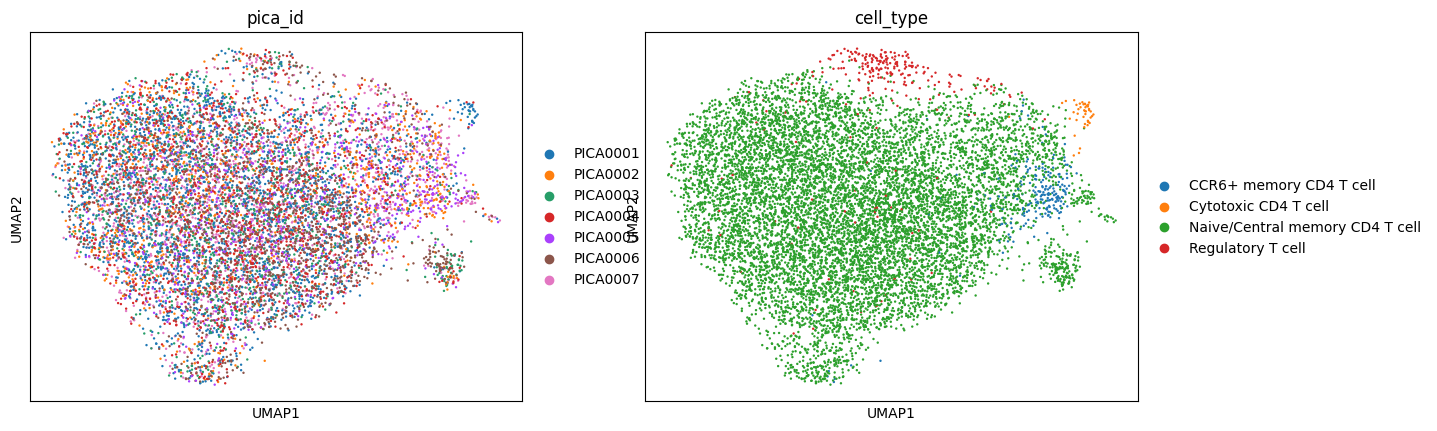

In [169]:
adata_cd4.obsm["X_scVI"] = model.get_latent_representation()

#  latent representation 
sc.pp.neighbors(adata_cd4, use_rep="X_scVI")
sc.tl.umap(adata_cd4)


sc.pl.umap(adata_cd4, color=[ "pica_id", 'cell_type'], save="_scvi_integrated_umap.png")

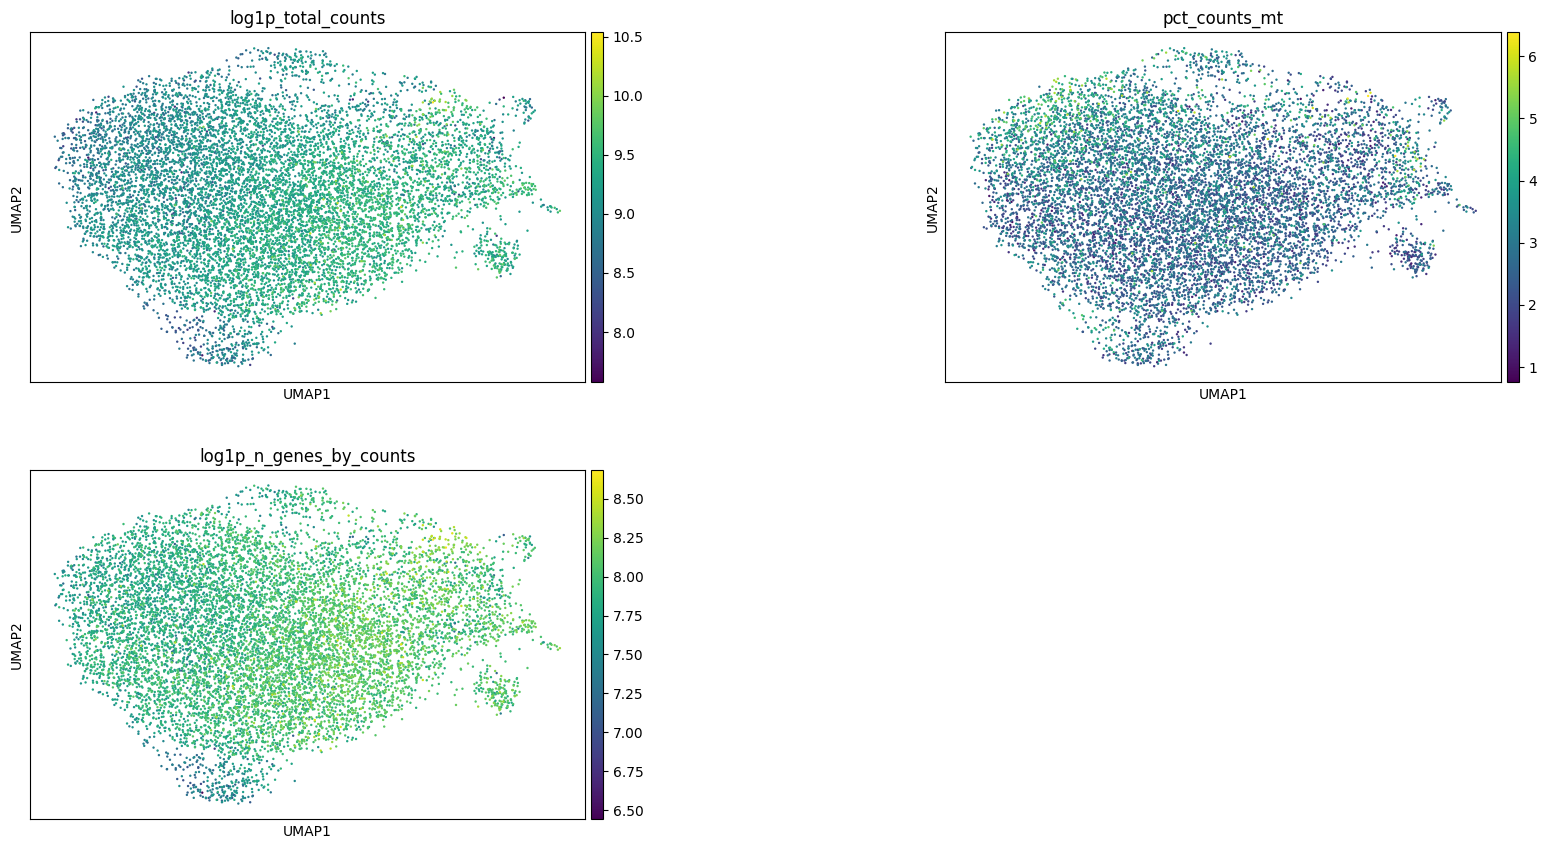

In [170]:
sc.pl.umap(
    adata_cd4,
    color=["log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
    save="_scvi_qc.png"
)

In [171]:
# Save the scVI integrated batch adata
adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_scVI.h5ad", compression='gzip')

#### 2. Clustering
- resolutions
- known marker genes to see if they align with cluster size

In [172]:
# Test different resolutions for Leiden clustering
# Higher resolution will result in more clusters, lower resolution will result in fewer clusters
for res in [ 0.5, 1.0, 1.5, 2.0]:
    sc.tl.leiden(
        adata_cd4, key_added=f"leiden_res_{res:3.1f}", resolution=res, flavor="igraph"
    )

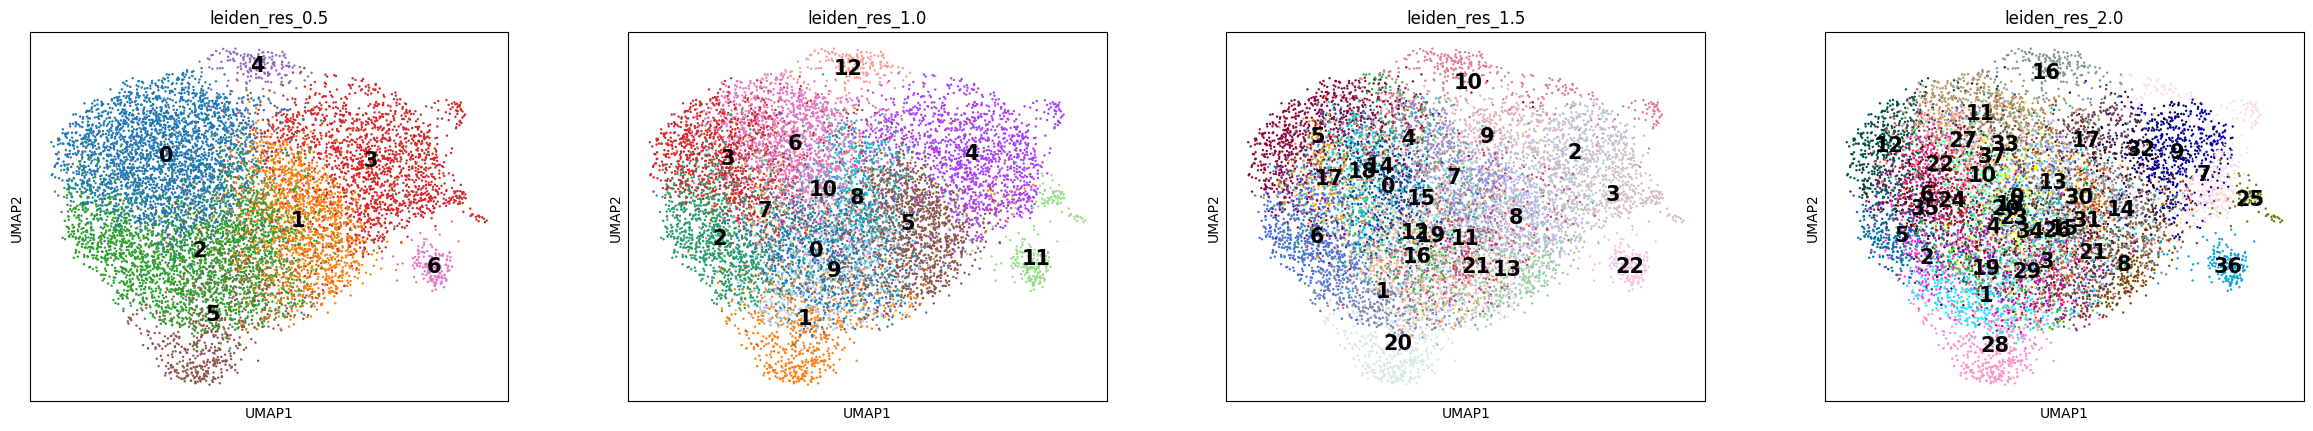

In [173]:
sc.pl.umap(
    adata_cd4,
    color=[ "leiden_res_0.5", "leiden_res_1.0","leiden_res_1.5", "leiden_res_2.0"],
    legend_loc="on data", legend_fontsize = 15
)

In [174]:
# Save the clustered adata
adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_scVI_cluster.h5ad", compression='gzip')
print(adata_cd4)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', 'leiden_res_0.5', 
'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'umap', 'cell_type_colors', 'leiden_res_0.5', 
'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'leiden_res_0.5_colors', 'leiden_res_1.0_colors', 
'leiden_res_1.5_colors', 'leiden_res_2.0_colors'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

##### 3. CD4 subset validation

In [176]:
broad_marker_genes = {
    "B cell": ["BLNK", "CD19", "CD79A", "CD79B", "MS4A1", "CD37", "CD79A"],
    "Plasmablast": ["CD19", "CD24", "CD38"], # experiment
    "Dendritic cell": ["CLEC4C", "IL3RA", "NRP1", "CD1C", "CST3", "FCER1A", "CD123", "GZMB"],
    "Endothelial cell": ["CDH5", "SELE", "VWF"],
    "Fibroblast": ["COL1A1", "COL3A1", "FAP", "THY1"],
    'Neutrophils': ['S100A8', 'S100A9', 'CEACAM8', 'ELANE', 'CSF3R', 'MPO'],  # CEACAM8 is highly specific neutrophil marker
    'Eosinophils': ['IL5RA', 'CCR3', 'EPX', 'PRG2', 'GATA1', 'CLC'],  
    'Basophils': ['FCER1A', 'KIT', 'CPA3', 'HPGDS', 'ENPP3'],  
    "Classical monocyte": ["CD14", "FCGR3A", "LYZ", "FCGR1A", 'CCR2', 'S100A8', 'S100A9'], # CD14⁺ CD16/FCGR3A⁻
    "Intermediate monocyte": ["CD14", "FCGR3A", "HLA-DRA", "CCL2", 'ITGAX'], # CD14⁺ CD16⁺
    "Non-classical monocyte": ["CD14", "FCGR3A", "TREML4", "NR4A1", 'CX3CR1', 'HLA-DPB1'], # CD14⁻CD16⁺
    "Natural killer cell": ["CCL3", 'CD160', 'CD247', 'GNLY', 'GZMB', 'NKG7', 'FCGR3A', 'FCGR3B', 'KLRB1', 'KLRC1', 'KLRD1', 'KLRF1', 'KLRK1', 'NCAM1'],
    "Platelet": ["CD41", "ITGA2B", "CD34", "CD61", "PF4", 'PLA2G12A', 'PPBP'], # No megakaryocyte in blood
    'HSPC': ['CD34', 'CD38', 'THY1', 'KIT', 'PROM1', 'SLAMF1', 'ITGA6'],
    "T cell": ['CD3D', 'CD3E', 'CD3G', 'TRAC', 'TRBC1', 'TRDC'],
    "CD4+ memory T cell": ['CCR7', 'CD27', 'IL7R'],
    "CD4+ T cell": ['CD4', 'CTLA4', 'FOXP3', 'IL2RA'],
    "CD8+ T cell": ['CD4', 'CD8A', 'CD8B', 'GZMK'],
    "Naive T cell": ['CCR7', 'CD27', 'CD8A', 'CD8B'],
    "Natural killer T (NKT) cell": ['CD8A', 'CD8B', 'ZNF683'],
}

In [177]:
adata_full = adata_cd4.raw.to_adata()
adata_full
present_marker_genes = {}

for celltype, markers in broad_marker_genes.items():
    present_markers = []
    for marker in markers:
        if marker in adata_full.var_names:
            present_markers.append(marker)
    present_marker_genes[celltype] = present_markers
print(present_marker_genes)

{
    'B cell': ['BLNK', 'CD19', 'CD79A', 'CD79B', 'MS4A1', 'CD37', 'CD79A'],
    'Plasmablast': ['CD19', 'CD24', 'CD38'],
    'Dendritic cell': ['CLEC4C', 'IL3RA', 'NRP1', 'CD1C', 'CST3', 'FCER1A', 'GZMB'],
    'Endothelial cell': ['CDH5', 'SELE', 'VWF'],
    'Fibroblast': ['COL1A1', 'COL3A1', 'FAP', 'THY1'],
    'Neutrophils': ['S100A8', 'S100A9', 'CEACAM8', 'ELANE', 'CSF3R', 'MPO'],
    'Eosinophils': ['IL5RA', 'CCR3', 'EPX', 'PRG2', 'GATA1', 'CLC'],
    'Basophils': ['FCER1A', 'KIT', 'CPA3', 'HPGDS', 'ENPP3'],
    'Classical monocyte': ['CD14', 'FCGR3A', 'LYZ', 'FCGR1A', 'CCR2', 'S100A8', 'S100A9'],
    'Intermediate monocyte': ['CD14', 'FCGR3A', 'HLA-DRA', 'CCL2', 'ITGAX'],
    'Non-classical monocyte': ['CD14', 'FCGR3A', 'TREML4', 'NR4A1', 'CX3CR1', 'HLA-DPB1'],
    'Natural killer cell': [
        'CCL3',
        'CD160',
        'CD247',
        'GNLY',
        'GZMB',
        'NKG7',
        'FCGR3A',
        'FCGR3B',
        'KLRB1',
        'KLRC1',
        'KLRD1',
        'KLRF1',
        'KLRK1',
        'NCAM1'
    ],
    'Platelet': ['ITGA2B', 'CD34', 'PF4', 'PLA2G12A', 'PPBP'],
    'HSPC': ['CD34', 'CD38', 'THY1', 'KIT', 'PROM1', 'SLAMF1', 'ITGA6'],
    'T cell': ['CD3D', 'CD3E', 'CD3G', 'TRAC', 'TRBC1', 'TRDC'],
    'CD4+ memory T cell': ['CCR7', 'CD27', 'IL7R'],
    'CD4+ T cell': ['CD4', 'CTLA4', 'FOXP3', 'IL2RA'],
    'CD8+ T cell': ['CD4', 'CD8A', 'CD8B', 'GZMK'],
    'Naive T cell': ['CCR7', 'CD27', 'CD8A', 'CD8B'],
    'Natural killer T (NKT) cell': ['CD8A', 'CD8B', 'ZNF683']
}

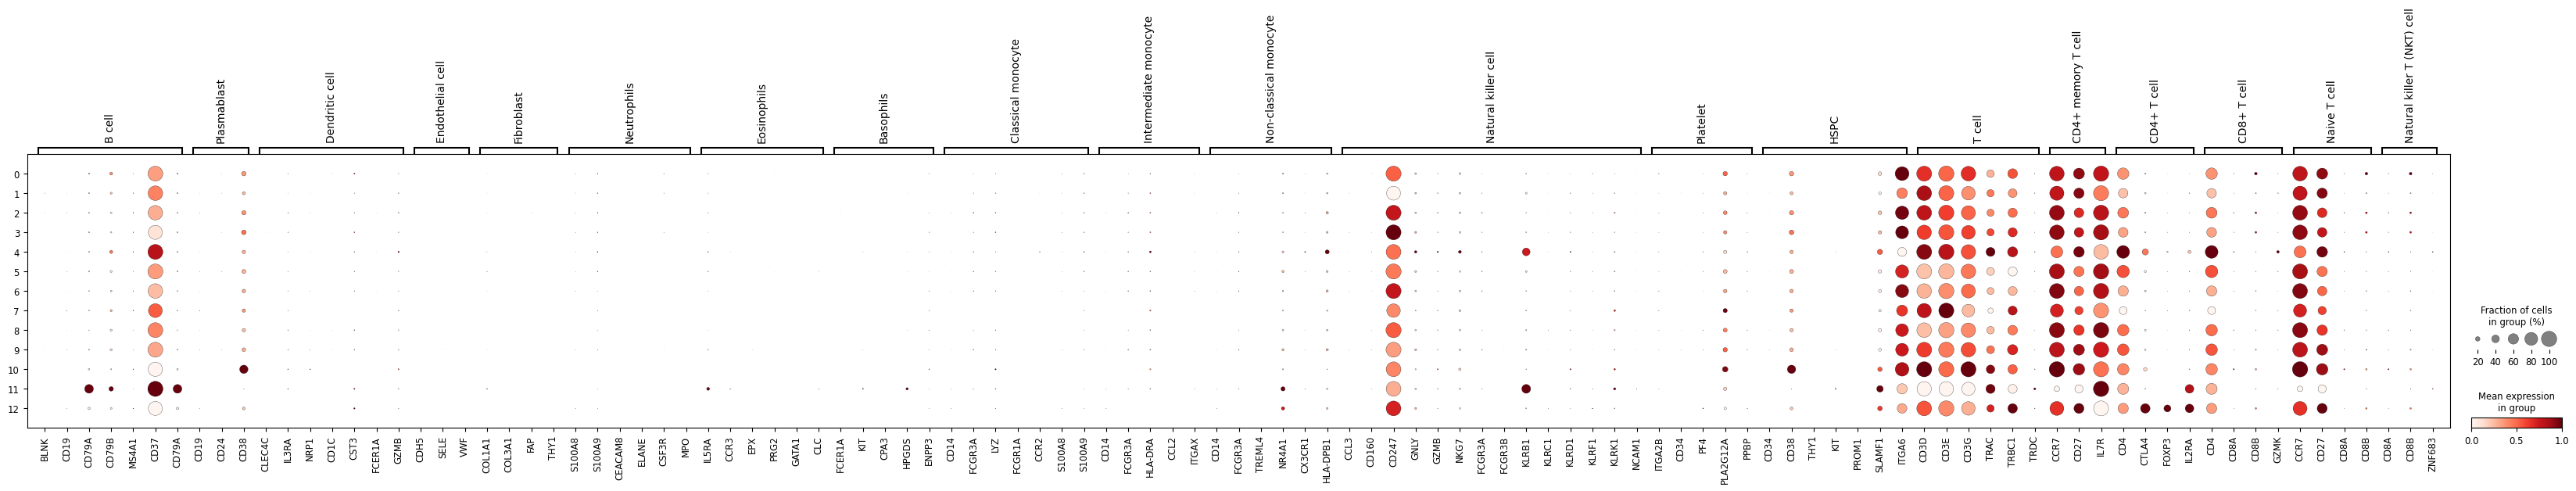

In [178]:
sc.pl.dotplot(adata_cd4, present_marker_genes , groupby="leiden_res_1.0", standard_scale="var", save="_all_markers.png")

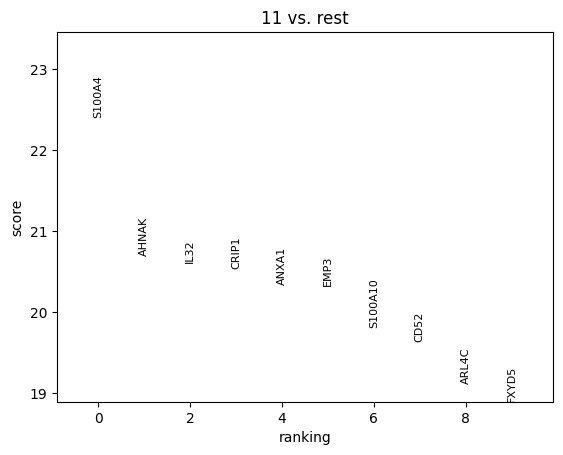

In [179]:
# Cluster 11 looks like B cell
sc.tl.rank_genes_groups(adata_cd4, groupby="leiden_res_1.0", groups=['11'], method="wilcoxon")
sc.pl.rank_genes_groups(adata_cd4, groupby="leiden_res_1.0", n_genes=10)

In [180]:
print(sc.get.rank_genes_groups_df(adata_cd4, group='11').head(30)["names"])

0       S100A4
1        AHNAK
2         IL32
3        CRIP1
4        ANXA1
5         EMP3
6      S100A10
7         CD52
8        ARL4C
9        FXYD5
10    SH3BGRL3
11       CLIC1
12      ZBTB16
13       ITGB1
14       NR4A2
15        SRGN
16        FTH1
17         FOS
18     LRRFIP1
19         EZR
20      NIBAN1
21        PLP2
22      ADAM19
23      TAGLN2
24       DUSP1
25     TAMALIN
26      S100A6
27       TIMP1
28        TPM3
29      PIK3R1
Name: names, dtype: object

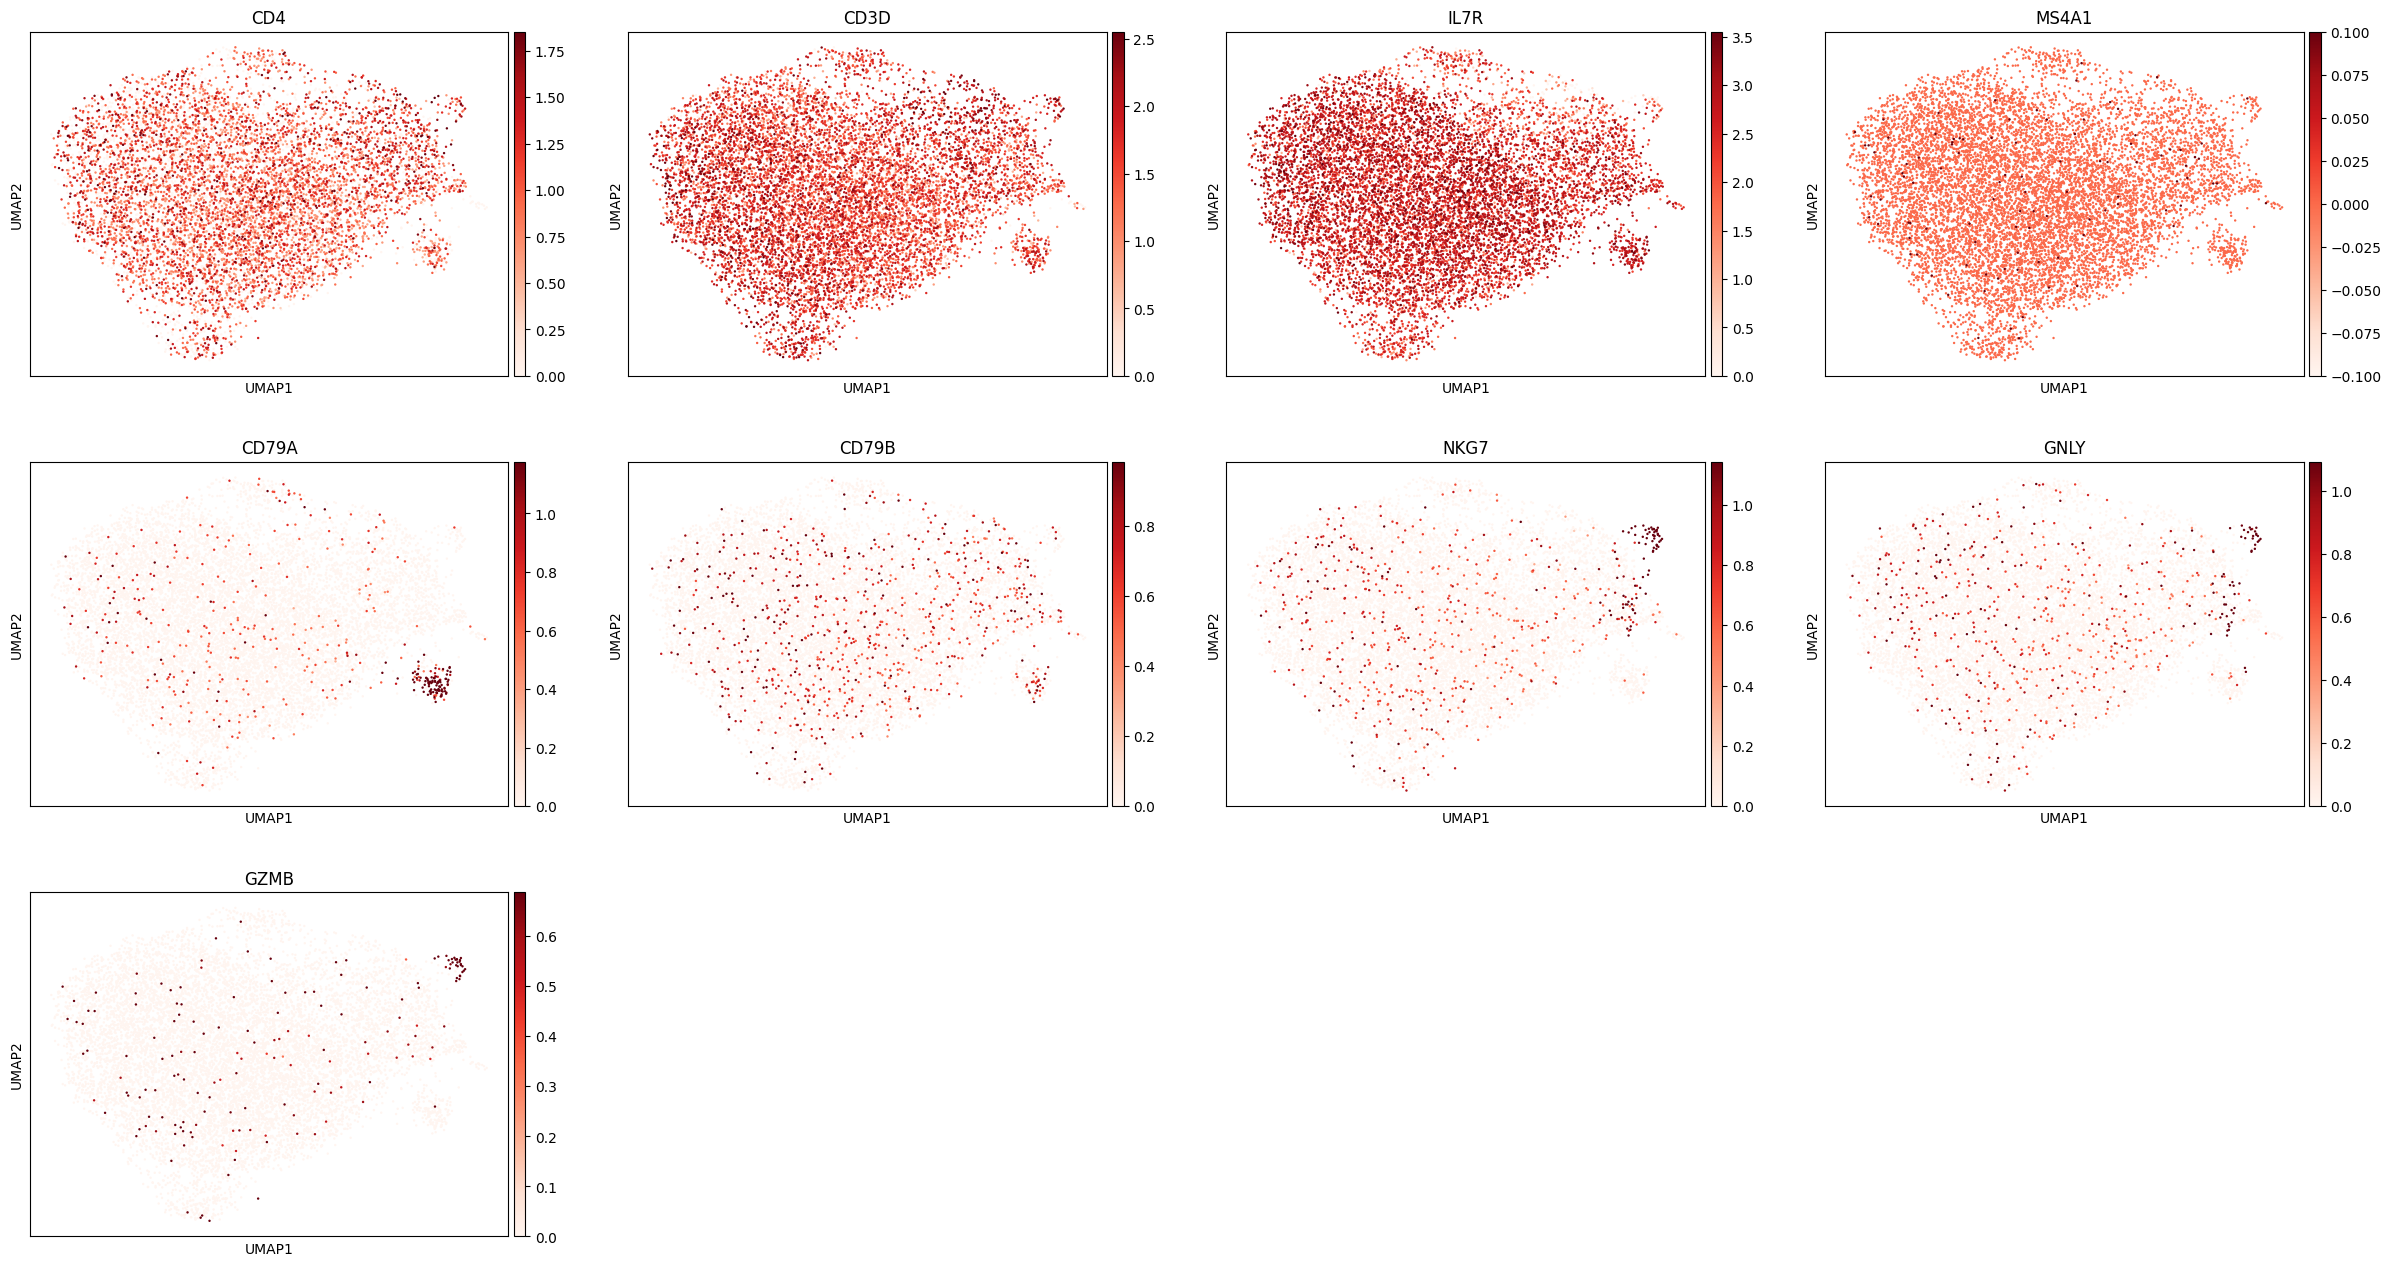

In [181]:
# check core marker expression overlays for cluster 11
sc.pl.umap(
    adata_cd4,
    color=["CD4","CD3D","IL7R",     # CD4 T markers
           "MS4A1","CD79A","CD79B", # B cell markers
           "NKG7","GNLY","GZMB"],   # NK / cytotoxic markers
    vmax="p99",
    cmap="Reds",
    save="_cluster11_marker_overlays.png"
)

- Cluster 11 seems to be CD4 (effector-like)
absence of B cell lineage markers and the presence of IL32, SRGN, DUSP1, FOS, JUN, TAGLN2 suggests it is an activated CD4⁺ T cell cluster (possibly effector-like)
- NK signal = CD4 cytotoxic T cells

In [182]:
# Save the updated raw adata
adata_cd4.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_cd4_annotations.h5ad", compression='gzip')